In [1]:
import os
import functools
import operator
import concurrent.futures

In [2]:
import h5py
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [3]:
import lib

In [4]:
lib.plotting.setup()

In [16]:
onecolumn_kwargs = {
    "width": 1 + 1/3,
    "height": 1 + 1/3,
    "horizontal_margin": 1/6,
    "vertical_margin": 1/3,
    "horizontal_gutter": 0,
    "fig_width": 3,
    "fig_height": 2,
}
twocolumn_kwargs = {
    "width": 1 + 1/3,
    "height": 1 + 1/3,
    "horizontal_margin": 5/6,
    "vertical_margin": 1/3,
    "top_margin": 1/3 + 1/4,
    "horizontal_gutter": 0,
    "fig_width": 7,
    "fig_height": 2.25,
}

In [6]:
shear_step_plus = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"
shear_step_minus = "g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

assert shear_step_plus in lib.const.SHEAR_STEPS
assert shear_step_minus in lib.const.SHEAR_STEPS

In [7]:
 with (
        h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_plus], "r") as shear_sim_plus,
        h5py.File(lib.const.SIM_REDSHIFT_CATALOGS[shear_step_plus], "r") as redshift_sim_plus,
        h5py.File(lib.const.SIM_WEIGHT_CATALOGS[shear_step_plus], "r") as weight_plus,
        h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_minus], "r") as shear_sim_minus,
        h5py.File(lib.const.SIM_REDSHIFT_CATALOGS[shear_step_minus], "r") as redshift_sim_minus,
        h5py.File(lib.const.SIM_WEIGHT_CATALOGS[shear_step_minus], "r") as weight_minus,
        h5py.File(lib.const.Y6_SHEAR_CATALOG, "r") as shear_y6,
        h5py.File(lib.const.Y6_REDSHIFT_CATALOG, "r") as redshift_y6,
    ):
        mdet_step = "noshear"
            
        cell_sim_plus = lib.tomography.get_assignment(shear_sim_plus, redshift_sim_plus, mdet_step)
        statistical_weight_plus = weight_plus["mdet"]["noshear"]["statistical_weight"][:]
        nz_match_plus = weight_plus["mdet"]["noshear"]["nz_weight"][:]
        w_match_plus = weight_plus["mdet"]["noshear"]["occupancy_weight"][:]
        nbr_match_plus = weight_plus["mdet"]["noshear"]["neighbor_weight"][:]

            
        cell_sim_minus = lib.tomography.get_assignment(shear_sim_minus, redshift_sim_minus, mdet_step)
        statistical_weight_minus = weight_minus["mdet"]["noshear"]["statistical_weight"][:]
        nz_match_minus = weight_minus["mdet"]["noshear"]["nz_weight"][:]
        w_match_minus = weight_minus["mdet"]["noshear"]["occupancy_weight"][:]
        nbr_match_minus = weight_minus["mdet"]["noshear"]["neighbor_weight"][:]
        
        cell_y6 = lib.tomography.get_assignment(shear_y6, redshift_y6, mdet_step)
        weight_y6 = lib.weight.get_shear_weights(shear_y6["mdet"][mdet_step])

        # ---

        _som_weight_sim_plus, _, _ = stats.binned_statistic(
            cell_sim_plus,
            statistical_weight_plus,
            statistic="sum",
            bins=lib.const.CELL_IDS,
        )
        som_occupancy_sim_plus = _som_weight_sim_plus / sum(_som_weight_sim_plus)

        _som_weight_sim_minus, _, _ = stats.binned_statistic(
            cell_sim_minus,
            statistical_weight_minus,
            statistic="sum",
            bins=lib.const.CELL_IDS,
        )
        som_occupancy_sim_minus = _som_weight_sim_minus / sum(_som_weight_sim_minus)

        som_occupancy_sim = (som_occupancy_sim_plus + som_occupancy_sim_minus) / 2

        # ---
            
        _som_w_sim_plus, _, _ = stats.binned_statistic(
            cell_sim_plus,
            statistical_weight_plus * w_match_plus,
            statistic="sum",
            bins=lib.const.CELL_IDS,
        )
        som_w_sim_plus = _som_w_sim_plus / sum(_som_w_sim_plus)

        _som_w_sim_minus, _, _ = stats.binned_statistic(
            cell_sim_minus,
            statistical_weight_minus * w_match_minus,
            statistic="sum",
            bins=lib.const.CELL_IDS,
        )
        som_w_sim_minus = _som_w_sim_minus / sum(_som_w_sim_minus)

        som_w_sim = (som_w_sim_plus + som_w_sim_minus) / 2

        # ---
            
        _som_nz_sim_plus, _, _ = stats.binned_statistic(
            cell_sim_plus,
            statistical_weight_plus * nz_match_plus,
            statistic="sum",
            bins=lib.const.CELL_IDS,
        )
        som_nz_sim_plus = _som_nz_sim_plus / sum(_som_nz_sim_plus)

        _som_nz_sim_minus, _, _ = stats.binned_statistic(
            cell_sim_minus,
            statistical_weight_minus * nz_match_minus,
            statistic="sum",
            bins=lib.const.CELL_IDS,
        )
        som_nz_sim_minus = _som_nz_sim_minus / sum(_som_nz_sim_minus)

        som_nz_sim = (som_nz_sim_plus + som_nz_sim_minus) / 2

        # ---
            
        _som_nbr_sim_plus, _, _ = stats.binned_statistic(
            cell_sim_plus,
            statistical_weight_plus * nbr_match_plus,
            statistic="sum",
            bins=lib.const.CELL_IDS,
        )
        som_nbr_sim_plus = _som_nbr_sim_plus / sum(_som_nbr_sim_plus)

        _som_nbr_sim_minus, _, _ = stats.binned_statistic(
            cell_sim_minus,
            statistical_weight_minus * nbr_match_minus,
            statistic="sum",
            bins=lib.const.CELL_IDS,
        )
        som_nbr_sim_minus = _som_nbr_sim_minus / sum(_som_nbr_sim_minus)

        som_nbr_sim = (som_nbr_sim_plus + som_nbr_sim_minus) / 2
      
        # ---

        _som_weight_y6, _, _ = stats.binned_statistic(
            cell_y6,
            weight_y6,
            statistic="sum",
            bins=lib.const.CELL_IDS,
        )
        som_occupancy_y6 = _som_weight_y6 / sum(_som_weight_y6)

        # ---

        occupancy_difference = som_occupancy_sim - som_occupancy_y6
        occupancy_ratio = som_occupancy_sim / som_occupancy_y6

        w_difference = som_w_sim - som_occupancy_y6
        w_ratio = som_w_sim / som_occupancy_y6

        nz_difference = som_nz_sim - som_occupancy_y6
        nz_ratio = som_nz_sim / som_occupancy_y6

        nbr_difference = som_nbr_sim - som_occupancy_y6
        nbr_ratio = som_nbr_sim / som_occupancy_y6

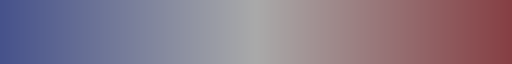

In [8]:
_cmap = LinearSegmentedColormap.from_list("", [
    (0.2759976400017525, 0.3225096299269912, 0.5477585030435282, 1.0),
    (2/3, 2/3, 2/3, 1.0),
    (0.5268264490099523, 0.2475770194988413, 0.26559200123532123, 1.0),
]).with_extremes(over="black", under="white")
_cmap

/global/u2/s/smau/projects/des/y6-image-sims-analysis/plots/lib/plotting.py:214: UserWarning: Total axes width (2.9999999999999996) less than figure width (3.0)
  warnings.warn(f"Total axes width ({total_width}) less than figure width ({fig_width})")
/global/u2/s/smau/projects/des/y6-image-sims-analysis/plots/lib/plotting.py:219: UserWarning: Total axes height (1.9999999999999998) less than figure height (2.0)
  warnings.warn(f"Total axes height ({total_height}) less than figure height ({fig_height})")


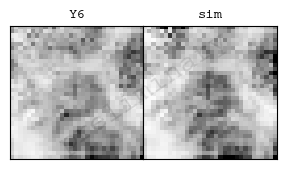

In [9]:
# fig, axs = plt.subplots(1, 4, figsize=(7, 3), sharex=True, sharey=True)
# fig.subplots_adjust(wspace=0, hspace=0)

fig, axs = lib.plotting.make_axes(
    1, 2,
    **onecolumn_kwargs,
)

norm = mpl.colors.Normalize(vmin=0)
cmap = "binary"


im = axs[0].imshow(
    som_occupancy_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
axs[0].set_title("Y6")


im = axs[1].imshow(
    som_occupancy_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
axs[1].set_title("sim")

# lib.plotting.add_colorbar(axs[3], im, label="Occupancy Ratio", extend="max")

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])


lib.plotting.watermark(fig)

plt.savefig("occupancy.pdf")

plt.show()

/global/u2/s/smau/projects/des/y6-image-sims-analysis/plots/lib/plotting.py:214: UserWarning: Total axes width (6.999999999999999) less than figure width (7.0)
  warnings.warn(f"Total axes width ({total_width}) less than figure width ({fig_width})")


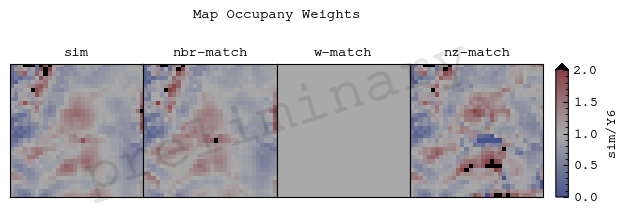

In [18]:
# fig, axs = plt.subplots(1, 4, figsize=(7, 3), sharex=True, sharey=True)
# fig.subplots_adjust(wspace=0, hspace=0)

fig, axs = lib.plotting.make_axes(
    1, 4,
    **twocolumn_kwargs,
)

norm = mpl.colors.Normalize(vmin=0)
cmap = "binary"

ratio_norm = mpl.colors.CenteredNorm(1, 1)
ratio_cmap = _cmap
# ratio_norm = mpl.colors.BoundaryNorm(np.linspace(0, 2, 12), ratio_cmap.N)


im = axs[0].imshow(
    occupancy_ratio.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=ratio_norm,
    cmap=ratio_cmap,
)
axs[0].set_title("sim")


im = axs[1].imshow(
    nbr_ratio.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=ratio_norm,
    cmap=ratio_cmap,
)
axs[1].set_title("nbr-match")


im = axs[2].imshow(
    w_ratio.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=ratio_norm,
    cmap=ratio_cmap,
)
axs[2].set_title("w-match")


im = axs[3].imshow(
    nz_ratio.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=ratio_norm,
    cmap=ratio_cmap,
)
axs[3].set_title("nz-match")

# cb = fig.colorbar(im, ax=axs[:], location="right", label="Occupancy Ratio", extend="max")
lib.plotting.add_colorbar(axs[3], im, label="$sim / Y6$", extend="max")

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("Map Occupany Weights")


lib.plotting.watermark(fig)

plt.savefig("occupancy_weights.pdf")

plt.show()

In [244]:
_cmap_negative = lib.plotting.cubehelix_colormap(
    start=0,
    rot=-0.1,
    gamma=1,
    hue=1,
    light=2/3,
    dark=1/3,
    reverse=False,
    name="m",
)
_cmap_negative_gray = lib.plotting.cubehelix_colormap(
    start=0,
    rot=-0.1,
    gamma=1,
    hue=0,
    light=2/3,
    dark=1/3,
    reverse=False,
    name="m",
)
_cmap_positive = lib.plotting.cubehelix_colormap(
    start=1,
    rot=-0.1,
    gamma=1,
    hue=1,
    light=2/3,
    dark=1/3,
    reverse=True,
    name="p",
)
_cmap_positive_gray = lib.plotting.cubehelix_colormap(
    start=1,
    rot=-0.1,
    gamma=1,
    hue=0,
    light=2/3,
    dark=1/3,
    reverse=True,
    name="p",
)

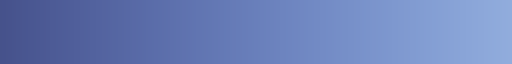

In [245]:
_cmap_negative

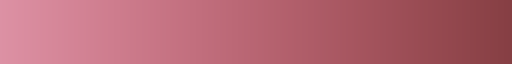

In [246]:
_cmap_positive